# Moving body

This notebook demonstrates the use of conformally-mapped bodies and edge conditions to generate flows in which vorticity is released from one or two edges.

In [1]:
using PotentialFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


## Set up

The following function computes the right-hand side of the evolution equation. At the beginning of every time-step, we first determine the bound vortex sheet strength required to satisfy the no-flow-through condition, then velocity of all vortex elements. Finally, we need to transform the computed velocities so that they apply to the elements in the circle plane.

In [3]:
function compute_ẋ!(ẋ, x, t)    
    body, ambient_sys = x
    motion = ẋ[1]
    # update the instantaneous motion of the body with the current motion
    motion.ċ, motion.c̈, motion.α̇, motion.α̈ = motion.kin(t)
    
    Bodies.enforce_no_flow_through!(body, motion, ambient_sys, t)
    
    # Zero the velocity
    reset_velocity!(ẋ, x)
        
    # Compute the self-induced velocity of the system
    self_induce_velocity!(ẋ, x, t)
    
    # Modify the velocity so that it provides the rate of change in the circle plane.
    Bodies.transform_velocity!(ẋ, ẋ, x, body)
end

compute_ẋ! (generic function with 1 method)

Once we have advected all the vortex elements, we release new blobs from the designated edges of the body. This function adds new blobs to the set with the correct strength to enforce edge conditions.

In [5]:
function shed_new_vorticity!(blobs, edge1, edge2, body, motion, t, spcrit1 = 0.0, spcrit2 = 0.0)    
    # assume that sheet positions are in the circle plane
    
    ϕ = 1/3 # fractional distance from the edge point to the previous blob
    
    # Location edges in physical plane
    zedge1 = body.zs[edge1] # body.c + body.m.z[edge1]*exp(im*body.α)
    zedge2 = body.zs[edge2] # body.c + body.m.z[edge2]*exp(im*body.α)
    
    # positions of previously-released blobs, transformed to physical plane
    zblob1 = conftransform(blobs[end-1].z,body)
    zblob2 = conftransform(blobs[end].z,body)

    # positions of new blobs in physical plane
    z1 = ϕ*zblob1 + (1-ϕ)*zedge1
    z2 = ϕ*zblob2 + (1-ϕ)*zedge2

    # positions of new blobs in circle plane
    ζ1 = inverse_conftransform(z1,body)
    ζ2 = inverse_conftransform(z2,body)

    # new blobs, with unit strength for now
    blob1 = Vortex.Blob(ζ1, 1.0, δ)
    blob2 = Vortex.Blob(ζ2, 1.0, δ)
     
    Bodies.enforce_no_flow_through!(body, motion, blobs, t) # need blobs in circle plane
    
    # Determine the strengths of the new blobs
    Γ1, Γ2 = Bodies.vorticity_flux(body, edge1, edge2, (body,blobs), [blob1], [blob2], t, spcrit1, spcrit2);
    
    # Add the new blobs to the list
    push!(blobs, Vortex.Blob(ζ1, Γ1, blobs[1].δ), Vortex.Blob(ζ2, Γ2, blobs[1].δ))
    
end

shed_new_vorticity! (generic function with 3 methods)

## Set up the body

### A bent plate

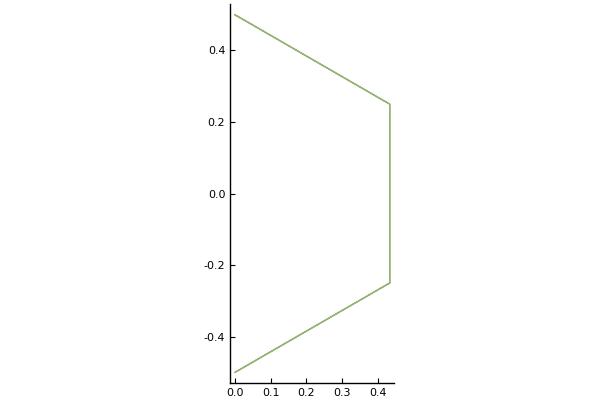

In [13]:
L = 1
nv = 4 # number of vertices
θ = range(0,π,length=nv)
xv = [0.5L*cos.(θ);reverse(0.5L*cos.(θ[2:end-1]))]
yv = [0.5L*sin.(θ);reverse(0.5L*sin.(θ[2:end-1]))]
p = Bodies.Polygon(xv,yv);
c = 0.0+0.0im
α₀ = -π/2   # angle of attack (this will become the mean angle in oscillatory pitching/heaving)
ċ = 1  # translation velocity
b = Bodies.ConformalBody(p,c,α₀)
plot(b)

#### Designate edges from which to release vortices. You can select one or two.

In [18]:
edgeindices = findall(b.m.angle .== minimum(b.m.angle)) # Look for vertices that have interior angle = 0
kLE = edgeindices[1] # edge 1 for releasing vorticity
kTE = edgeindices[2] # edge 2 for releasing vorticity

5

Check that these are the correct edges by checking their positions

In [19]:
b.zs[[kLE,kTE]]

2-element Array{Complex{Float64},1}:
 3.061616997868383e-17 - 0.5im
 3.061616997868383e-17 + 0.5im

### Set up the motion. Here are two possibilities:

#### Simple steady translation

In [20]:
motion = Plates.RigidBodyMotion(ċ, 0.0)
α = α₀;

#### Oscillatory pitching and heaving
If you simply desire steady translation, then do not run this cell or the next one.

Take note of the χ parameter below. If it is less than 1, then there is a tendency for a plate or airfoil to generate thrust rather than drag.

In [68]:
a = 0.25 # location of pitch axis, a = 0.5 is leading edge
ϕ = 0 #π/2  # phase lag of pitch to heave
A = 0.025  # amplitude/chord
fstar = 1/π # fc/U
Δα = 10π/180 # amplitude of pitching

K = π*fstar # reduced frequency, K = πfc/U
χ = Δα/atan(2π*A*fstar)

println("f* = ",fstar)
println("Δα = ",Δα*180/π)
println("α(1/4) = ",abs(atan(2*K*A)-Δα)*180/π)
println("A/c = ",A)
println("K = ",K)
println("χ = ",χ)

oscil = RigidBodyMotions.PitchHeave(real(ċ),a,K,ϕ,α₀,Δα,A);
motion = Plates.RigidBodyMotion(oscil);
α = oscil.α(0.0);

f* = 0.3183098861837907
Δα = 10.0
α(1/4) = 7.137594773888252
A/c = 0.025
K = 1.0
χ = 3.493565449355982


#### Plot of the effective angle of attack for oscillatory pitching and heaving

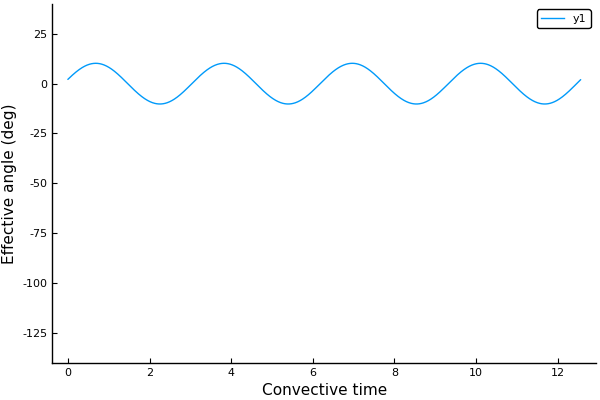

In [39]:
trange = 0:0.01:(4/fstar)
Vy = map(x -> imag(x[1]),oscil.(trange))
αeff = atan.(-Vy)+oscil.α.(trange)
plot(trange,αeff*180/π,ylim=(-140,40),ylabel="Effective angle (deg)",xlabel="Convective time")

### Initialize the problem

In [21]:
Δt = 5e-3; # time step

We place the initial blobs near the edges of the body.

#### NOTE: if you find you are getting an error, you might try changing the sign of Δz₀.

In [22]:
b = Bodies.ConformalBody(p,c,α)

edge1 = kLE # leading edge index
edge2 = kTE # trailing edge index

# blob radius
δ = 0.02/abs(b.m.constant)

# locations of edges in physical plane
zedge1, zedge2 = b.zs[[edge1,edge2]]

# Vector to add to these edges. This determines the initial placement of the first vortex elements relative
# to the edges.
Δz₀ = -3*im*Δt*exp(im*α)
#Δz₀ = -3*Δt+0.001im

# locations of initial blobs in circle plane
ζblob = inverse_conftransform(Δz₀ .+ [zedge1, zedge2],b)

# create the blobs, for now with unit strength
blobs = Vortex.Blob.(ζblob, 1.0, δ)

2-element Array{PotentialFlow.Blobs.Blob{Float64},1}:
 Vortex.Blob(0.9187499767669149 - 0.7728984863684385im, 1.0, 0.06041602095625204)
 Vortex.Blob(-0.918749977650974 - 0.7728984839177738im, 1.0, 0.06041602095625204)

We then adjust the circulation of the vortex blobs to satisfy the edge conditions.
In this library, the vorticity flux from the edge of the body is determined through the edge suction parameter.
The Kutta condition simply corresponds to the suction parameter being zero at the edge, whereas Inf suppresses shedding altogether from the edge.

#### NOTE: For problems involving small angle of attack, it is best to set spcrit1 to Inf to suppress vortex shedding from the leading edge.

In [153]:
# critical edge suction parameters
spcrit1 = 0 # leading edge. Make this Inf if you want to suppress vortex shedding from the leading edge.
spcrit2 = 0 # trailing edge

Bodies.enforce_no_flow_through!(b, motion, (), 0)
sys = (b,)

# This determines the circulations that enforce the edge conditions
Γ1, Γ2 = Bodies.vorticity_flux(b, edge1, edge2, sys, [blobs[1]], [blobs[2]], 0, spcrit1, spcrit2);

# Now create the blobs with the correct circulations
blobs = Vortex.Blob.(ζblob, [Γ1, Γ2], δ)

# This creates the image blobs, so that no-penetration condition is enforced
Bodies.enforce_no_flow_through!(b, motion, blobs, 0)

# Set up the initial system
ambient_sys = blobs
sys = (b, ambient_sys)
nothing

Set up initial data structures for the solution

In [154]:
t = 0.0

sys₊ = deepcopy(sys) # Used for storage during time-marching
#ẋs = [(motion, allocate_velocity(ambient_sys)) for k = 1:4]  # For RK4
ẋs = (motion, allocate_velocity(ambient_sys)) # For forward Euler method

# Storage
time = Float64[]
imp = ComplexF64[]

blob_z = conftransform(ambient_sys,b)
track = [deepcopy((b,blob_z))]

push!(imp,Elements.impulse((b,blob_z)))

tsamp = 0.25 # Rate at which to save system data in `track` array
nothing

## Time-Marching

We use forward Euler to evolve the system and apply filtering on the trailing edge vortex sheets to suppress small-scale instabilities.

In [161]:
tf = 0.25
T = 0:Δt:tf

for tloc in T
    b_now, ambient_ω_ζ = sys
    motion, ambient_u = ẋs
    
    resize!(sys₊[2], length(sys[2]))
    TimeMarching.forward_euler!(sys₊, sys, t, Δt, compute_ẋ!, advect!, ẋs)
    
    global sys₊, sys = sys, sys₊

    t += Δt
        
    shed_new_vorticity!(sys[2], edge1, edge2, sys[1], ẋs[1], t, spcrit1, spcrit2)
        
    # save stuff
    
    push!(time,t)
    
    b_now, ambient_ω_ζ = deepcopy(sys)
    blob_z = conftransform(ambient_ω_ζ,b_now)

    if isapprox(mod(t,tsamp),0.0;atol=1e-8) || isapprox(mod(t,tsamp),tsamp;atol=1e-8)        
        push!(track,deepcopy((b_now,blob_z)))
    end
    
    Bodies.enforce_no_flow_through!(b_now, motion, ambient_ω_ζ, t)
    push!(imp,Elements.impulse((b_now,blob_z)))
    
end
b_now, ambient_ω_ζ = sys
blob_z = conftransform(ambient_ω_ζ,b_now);

### Plot the flow field

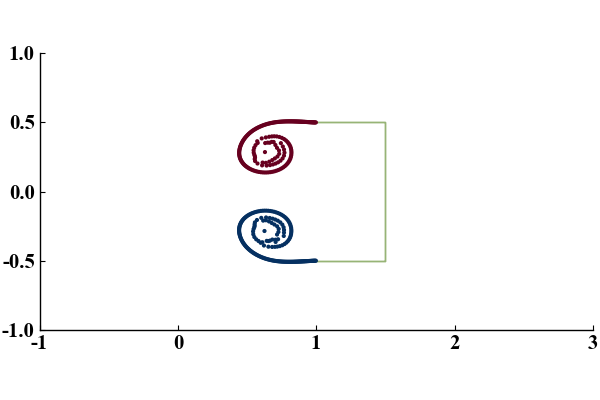

In [162]:
tkfont = Plots.font("Times New Roman",15)
ps = plot(track[end],legend=false,markerstrokewidth=0,color=:RdBu_r,clim=(-0.025/(2π),0.025/(2π)),markersize=3,tickfont=tkfont,ratio=1,xlim=(-1,3),ylim=(-1,1)) #

### Plot the force coefficients

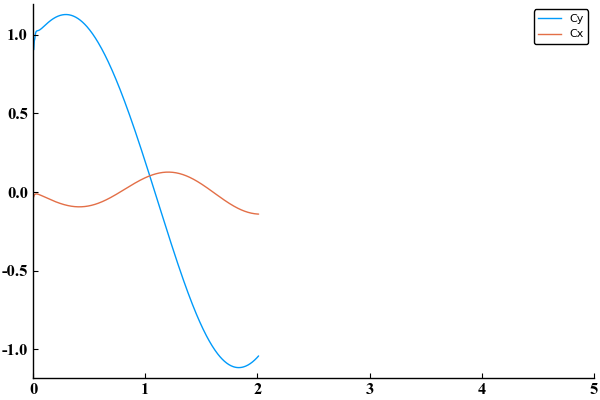

In [55]:
force = -diff(imp)/Δt
tkfont = Plots.font("Times New Roman",12)
plot(time,2*imag.(force),tickfont=tkfont,label="Cy",xlim=(0,5))
plot!(time,2*real.(force),label="Cx")

In [56]:
using Statistics

In [57]:
println("Mean lift coefficient = ",-Statistics.mean(2*imag.(force)))
println("Mean drag coefficient = ",-Statistics.mean(2*real.(force)))

Mean lift coefficient = -0.0784456925389099
Mean drag coefficient = 0.007804480521560913


### Plotting streamlines

Set up a polar grid on which to plot

In [97]:
rmax = 5.0   # largest radial coordinate (smallest is 1)
ϵ = 0.00001 # small offset from the surface of the unit circle

nth = 400   # number of circumferential points
dth = 2π/nth
θ = range(0,2π,length=nth+1)
dr = dth
r = [1+ϵ]
while maximum(r) < rmax
    push!(r,r[end]+dr)
    dr = r[end]*dth
end

Plot the streamlines of the current system of body and vortices

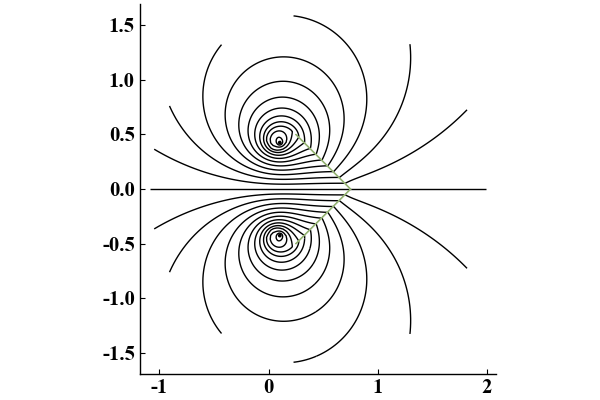

In [122]:
tkfont = Plots.font("Times New Roman",15)
ps = streamlines(r,θ,sys)
plot!(ps,b,legend=false,markerstrokewidth=0,color=:RdBu_r,clim=(-0.025/(2π),0.025/(2π)),markersize=3,tickfont=tkfont)